Для ДЗ взял соревнование Carvana Image Masking
https://www.kaggle.com/c/carvana-image-masking-challenge

Предложить своё решение еще не готов. Выбрал из доступных и разобрал решение https://www.kaggle.com/uysimty/carvana-image-masking

In [130]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from skimage import io, transform
import cv2
import tensorflow as tf

In [131]:
import os
print(os.listdir("./input/"))

['test_hq.zip', '29bb3ece3180_11.jpg', 'train_masks.zip', '.DS_Store', 'train_hq', 'test', 'test_', 'metadata.csv.zip', 'test.zip', 'train_masks.csv.zip', 'train', 'train_hq.zip', 'train.zip', 'train_masks', 'sample_submission.csv.zip']


In [179]:
# набор переменных

# Выключатель упрощенных минимальны параметров для обучения
# FAST_RUN=False
# FAST_PREDICT=False

# RGB картинка 128*128
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3

input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL) # входящий слой по размеру картинки
mask_shape=(IMAGE_WIDTH, IMAGE_HEIGHT) 
image_size=(IMAGE_WIDTH, IMAGE_HEIGHT) 

# настройки обучения
batch_size=10
epochs=3

In [133]:
# подгрузил имена и мету из zip

metadata = pd.read_csv("./input/metadata.csv.zip")
train_masks = pd.read_csv("./input/train_masks.csv.zip")
testdata = pd.read_csv("./input/sample_submission.csv.zip")

In [134]:
# Отобрал несколько картинок для примера
testdata = testdata[:9]

In [135]:
#  что внутри фреймов?

print('train_masks', train_masks.shape)
print('testdata', testdata.shape)
print('metadata', metadata.shape)

print('train_masks', train_masks.head())
print('testdata', testdata.head())
print('metadata', metadata.head())

train_masks (5088, 2)
testdata (9, 2)
metadata (6572, 6)
train_masks                    img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...
testdata                    img rle_mask
0  0004d4463b50_01.jpg      1 1
1  0004d4463b50_02.jpg      1 1
2  0004d4463b50_03.jpg      1 1
3  0004d4463b50_04.jpg      1 1
4  0004d4463b50_05.jpg      1 1
metadata              id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA

In [26]:
# Сокращение сета для обучения на минималках. Не использую.

# Fast run for development
# if FAST_RUN:
#     epochs=1
#     train_masks = train_masks.sample(1000).reset_index()

# if FAST_PREDICT: 
#     testdata = testdata.sample(batch_size).reset_index()

In [136]:
# добавил маску имён файлов и признак фото с поворотом

filenames = train_masks.img.str.split(".")
maskfilenames = filenames.str[0] + "_mask.gif"
train_masks['img_mask'] = maskfilenames
train_masks['angle'] = filenames.str[0].str.split("_").str[1].astype(int)
train_masks.head()

,img,rle_mask,img_mask,angle
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc_01_mask.gif,1
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc_02_mask.gif,2
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc_03_mask.gif,3
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc_04_mask.gif,4
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc_05_mask.gif,5


In [161]:
# print(sample.iterrows.__doc__)
# print(type(sample))
# sample.shape

,img,rle_mask,img_mask,angle
3297,a2df64508b97_02.jpg,541905 4 543822 6 545738 8 547655 10 549572 11...,a2df64508b97_02_mask.gif,2


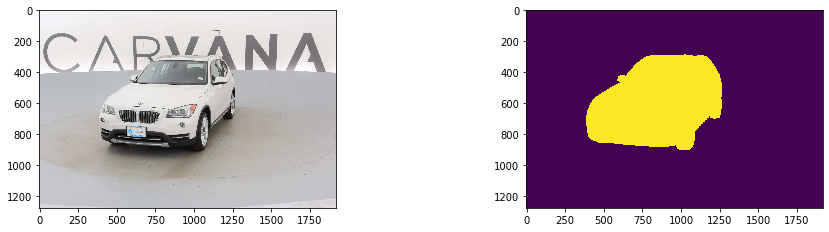

In [163]:
# просмотр

sample = train_masks.sample() # случайная запись
fig=plt.figure(figsize=(16, 8))

for index, s in sample.iterrows(): # итерация по выборке
    original_image = io.imread('./input/train/'+s.img)
    masked_image = io.imread('./input/train_masks/'+s.img_mask)

    # положение изображений
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)

    plt.subplot(2, 2, 2)
    plt.imshow(masked_image)
    
sample

In [165]:
from skimage.transform import AffineTransform, warp 

def shift(image, translation_matrix):
    '''Смещение изображения
    https://www.programcreek.com/python/example/96402/skimage.transform.warp
    '''
    transformer = AffineTransform(translation=translation_matrix)
    return warp(image, transformer, mode='wrap', preserve_range=True)

In [167]:
# Transform Image: Shift, Flip

def tranform_image(original_image, mask_image):
    '''Трансформация пары Изображение-Маска для увеличения обучающей выборки
    '''
    
    image = original_image
    mask = mask_image
    
    isHorizontalFlip = np.random.random() < 0.5
    isShift = np.random.random() < 0.5

    if isShift:
        translation_matrix = np.random.random_integers(-10, 10), np.random.random_integers(-10, 10)
        image = shift(image, translation_matrix)
        mask = shift(mask, translation_matrix)

    if isHorizontalFlip:
        image = image[:, ::-1]
        mask = mask[:, ::-1]
        
    image = image / 255.0
    mask = mask / 255.0
    
    return image, mask

In [168]:
# Define Image Generator

def data_gen_small(data_dir, mask_dir, df_data, precess_batch_size, original_image_shape, mask_image_shape):
    '''
    Преобразователь картинок
    '''
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, image_size, mode='constant')
                # masks
                original_mask = io.imread(mask_dir + row.img_mask, as_gray=True)
                resized_mask = transform.resize(original_mask, image_size, mode='constant')
                
                image, mask = tranform_image(resized_img, resized_mask)
                
                imgs.append(image)
                labels.append(np.expand_dims(mask, axis=2))
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [169]:
train_gen = data_gen_small("./input/train/", "./input/train_masks/", train_masks, batch_size, input_shape, mask_shape)

See how our generator work

/Users/daniilstv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  


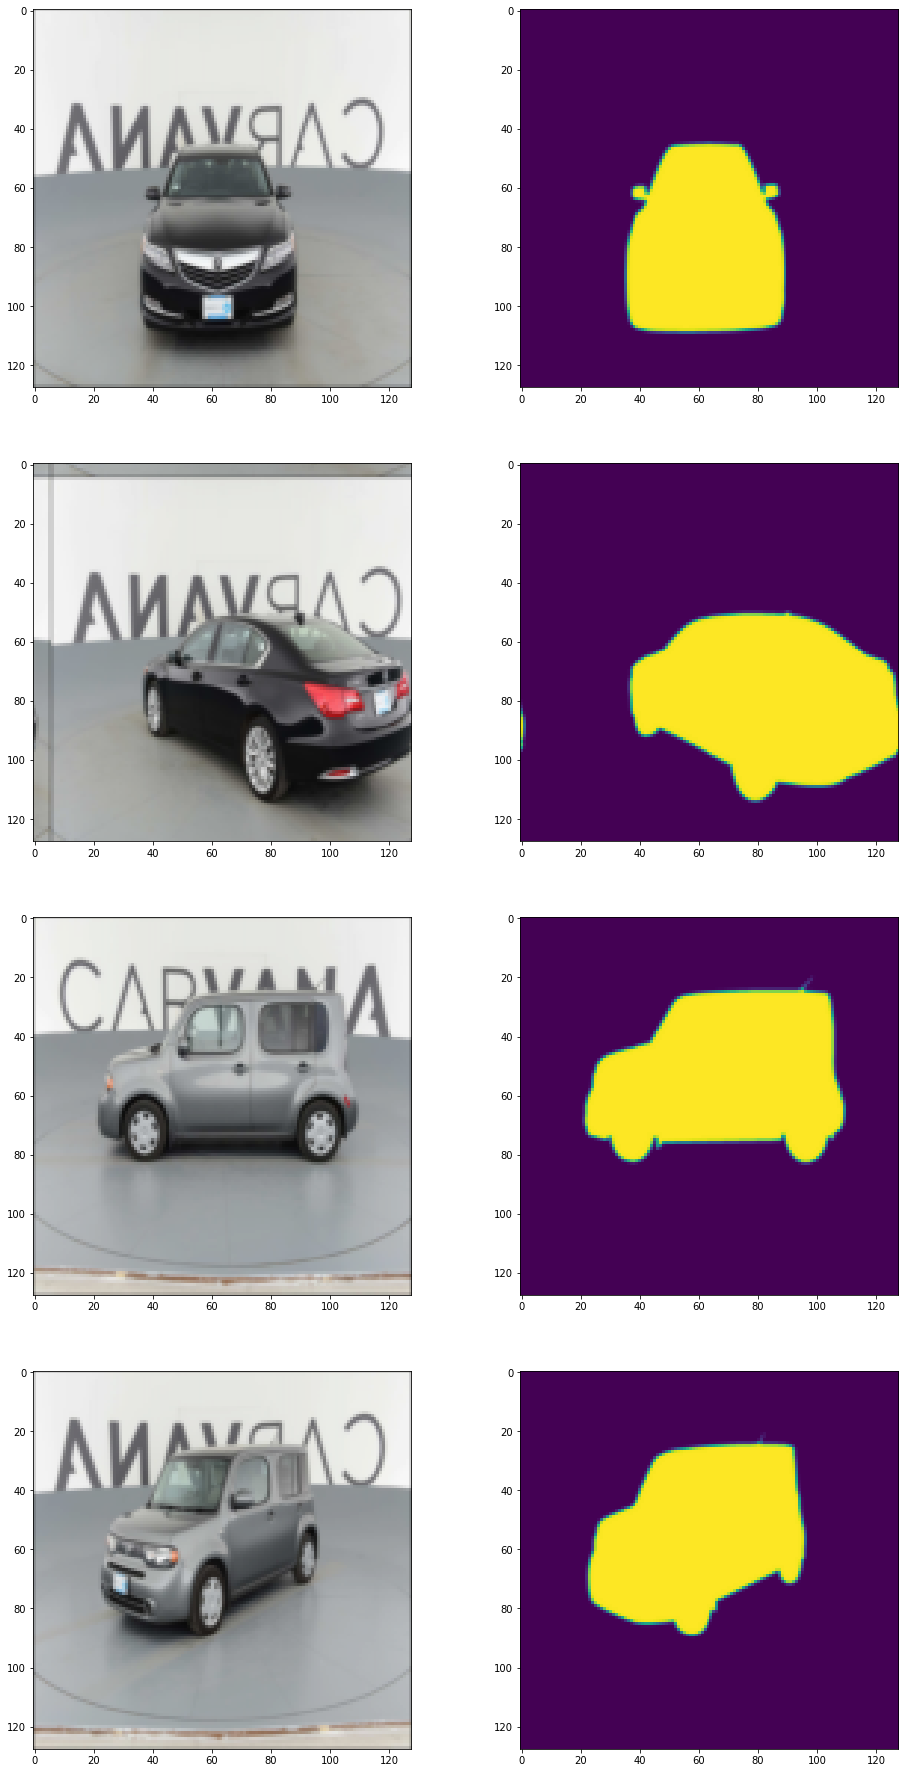

In [170]:
fig=plt.figure(figsize=(16, 32))
for i in [1, 2, 3, 4]:
    img, msk = next(train_gen)
    plt.subplot(4, 2, i*2-1)
    plt.imshow(img[0]*255.0)
    plt.subplot(4, 2, i*2)
    plt.imshow(msk[0].reshape(128, 128))
    

In [176]:
# U-Net нейросеть для определения контуров изображений

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

inputs = Input(shape=input_shape)
# 128 - вход

# последовательно нанизываем слои. Следующий опирается на предыдущий.

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64 - повышение абстракции - спуск по U. Увеличение нейронов в блоке

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # снижение разрешения чз MaxPooling
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8 

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center - 

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)  # вход с соотв. слоя повышения абстракции
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16 - подъём по U. Уменьшение нейронов в блоке (толщины), увеличение разрешения

up3 = UpSampling2D((2, 2))(up4) # повышение разрешения
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1) 

model = Model(inputs=inputs, outputs=outputs) # вход модели; выход через последовательность слоёв


In [178]:
# Компиляция структуры сети
optimizer = tf.compat.v1.train.RMSPropOptimizer(0.0001)

model.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"])

In [180]:
# Обучение на пяти эпохах

steps_per_epoch=np.ceil(float(len(train_masks)) / float(batch_size)).astype(int)
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

/Users/daniilstv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  


Epoch 1/5
509/509 [==============================] - 7218s 14s/step - loss: 0.3212 - accuracy: 0.6605
Epoch 2/5
509/509 [==============================] - 6575s 13s/step - loss: 0.0351 - accuracy: 0.7698
Epoch 3/5
509/509 [==============================] - 7010s 14s/step - loss: 0.0113 - accuracy: 0.7698
Epoch 4/5
509/509 [==============================] - 7073s 14s/step - loss: 0.0063 - accuracy: 0.7698
Epoch 5/5
509/509 [==============================] - 6655s 13s/step - loss: 0.0056 - accuracy: 0.7698


In [181]:
# Сохранить модель
model.save("model_2.h5")

In [182]:
# Define test generator
def test_gen_small(data_dir, df_data, precess_batch_size, original_image_shape):
    '''
    Ресайз картинок для применения модели
    '''
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, original_image_shape) / 255.0
                imgs.append(resized_img)

            imgs = np.array(imgs)
            yield imgs


In [183]:
#     Ресайз картинок для применения модели
test_gen = test_gen_small("./input/test_/", testdata, batch_size, input_shape)

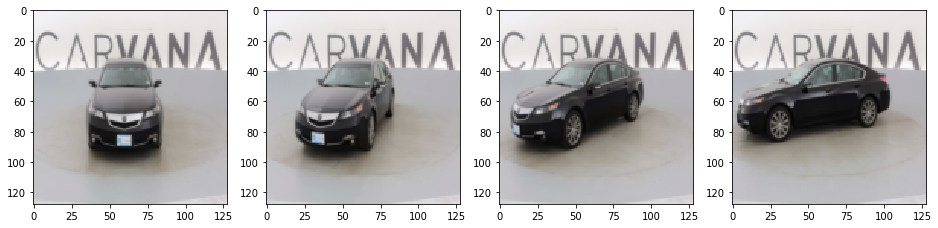

In [184]:
# Проверка ресайза
img = next(test_gen)
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    plt.subplot(1, 4, i)
    plt.imshow(img[i-1]*255.0)

In [185]:
# Предсказание на картинках из testdata - 9шт

steps = np.ceil(float(len(testdata)) / float(batch_size)).astype(int)
y_predicted = model.predict_generator(
    test_gen, 
    steps=steps
)

In [189]:
y_predict.shape
y_predict.reshape(128, 128)
print(y_predict.shape)

(128, 128)


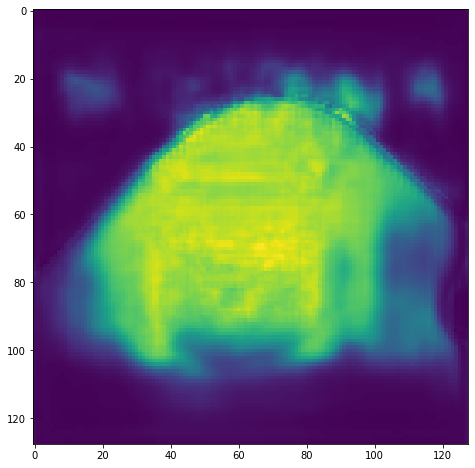

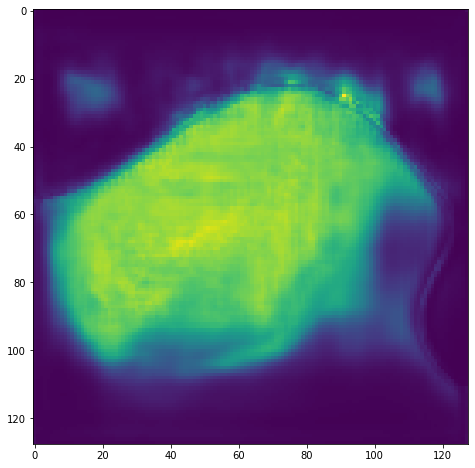

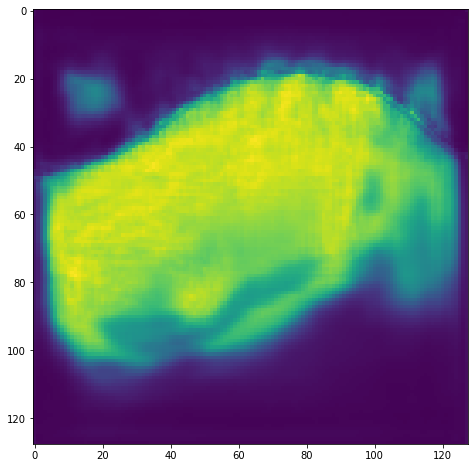

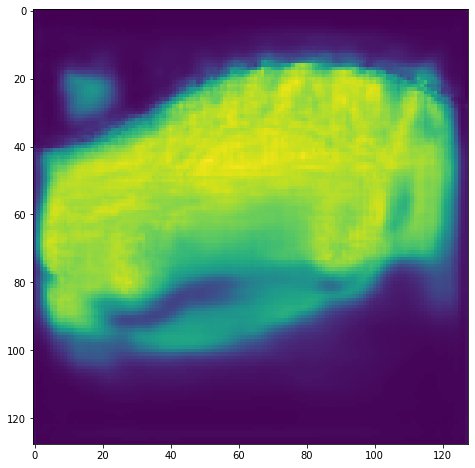

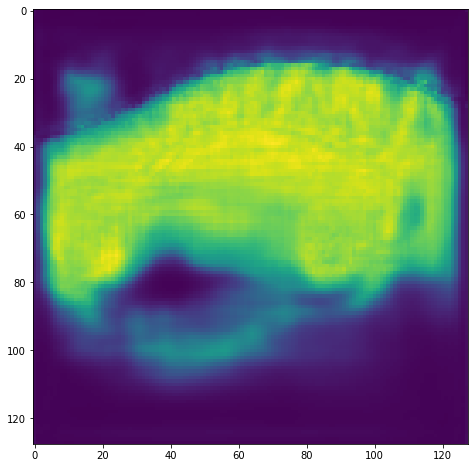

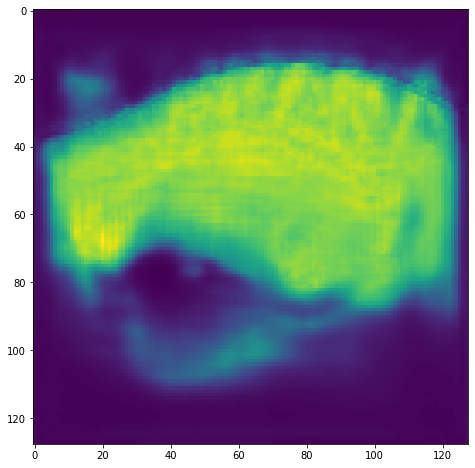

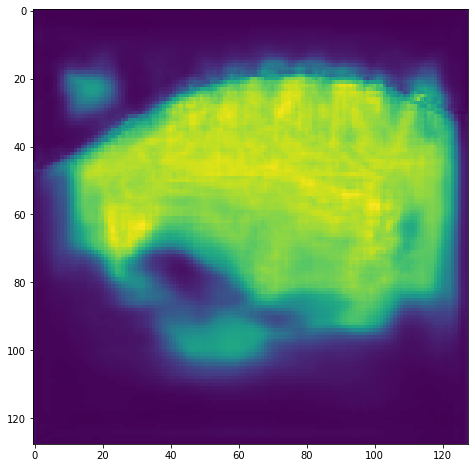

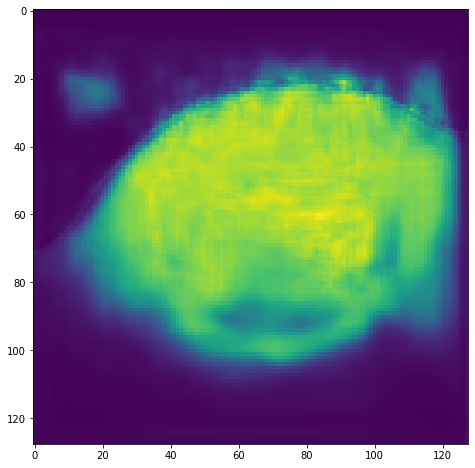

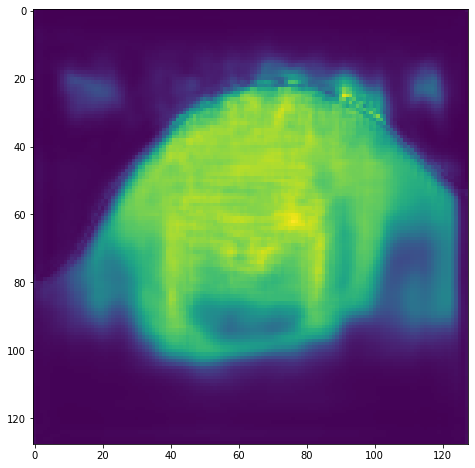

In [198]:
# Просмотр результата

for i in range(len(testdata)):
    y_predict = y_predicted[i]
    y_predict = y_predict.reshape(128, 128)
    fig=plt.figure(figsize=(16, 8))
    plt.subplot()
    plt.imshow(y_predict)

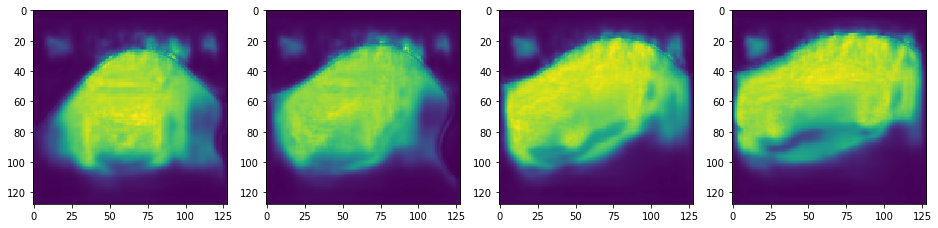

In [191]:
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    y_predict = y_predicted[i-1]
    plt.subplot(1, 4, i)
    plt.imshow(y_predict.reshape(128, 128))